# Step-62

## Set parameters

In [1]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
import numpy as np
import h5py
import matplotlib.pyplot as plt
import subprocess
import scipy.constants as constants
import scipy.optimize

# This considerably reduces the size of the svg data
plt.rcParams['svg.fonttype'] = 'none'

h5_file = h5py.File('results.h5', 'w')
data = h5_file.create_group('data')
displacement = data.create_group('displacement')
calibration = data.create_group('calibration')

# Set the parameters
for group in [displacement, calibration]:
    # Dimensions of the domain
    group.attrs['dimension_x'] = 0.02
    group.attrs['dimension_y'] = 2e-5
    
    # Position of the probe that we use to measure the flux
    group.attrs['probe_pos_x'] = 0.008
    group.attrs['probe_pos_y'] = 0
    group.attrs['probe_width_y'] = 2e-05
    
    # Number of points in the probe
    group.attrs['nb_probe_points'] = 5
    
    # Global refinement
    group.attrs['grid_level'] = 1

    # Cavity
    group.attrs['cavity_resonance_frequency'] = 20e6
    group.attrs['nb_mirror_pairs'] = 15

    # Material
    group.attrs['poissons_ratio'] = 0.27
    group.attrs['youngs_modulus'] = 270000000000.0
    group.attrs['material_a_rho'] = 3200
    if group == displacement:
        group.attrs['material_b_rho'] = 2000
    else:
        group.attrs['material_b_rho'] = 3200   
    group.attrs['lambda'] = (group.attrs['youngs_modulus'] * group.attrs['poissons_ratio'] /
                           ((1 + group.attrs['poissons_ratio']) *
                           (1 - 2 * group.attrs['poissons_ratio'])))
    group.attrs['mu']= (group.attrs['youngs_modulus'] / (2 * (1 + group.attrs['poissons_ratio'])))

    # Force
    group.attrs['max_force_amplitude'] = 1e20
    group.attrs['force_sigma_x'] = 1
    group.attrs['force_sigma_y'] = 1
    group.attrs['max_force_width_x'] = 0.0003
    group.attrs['max_force_width_y'] = 0.001
    group.attrs['force_x_pos'] = -0.008
    group.attrs['force_y_pos'] = 0

    # PML
    group.attrs['pml_x'] = True
    group.attrs['pml_y'] = False
    group.attrs['pml_width_x'] = 0.0018
    group.attrs['pml_width_y'] = 0.0005
    group.attrs['pml_coeff'] = 1.6
    group.attrs['pml_coeff_degree'] = 2

    # Frequency sweep
    group.attrs['center_frequency'] = 20e6
    group.attrs['frequency_range'] = 0.5e6
    group.attrs['start_frequency'] = group.attrs['center_frequency'] - group.attrs['frequency_range'] / 2
    group.attrs['stop_frequency'] = group.attrs['center_frequency'] + group.attrs['frequency_range'] / 2
    group.attrs['nb_frequency_points'] = 400

    # Other parameters
    if group == displacement:
        group.attrs['simulation_name'] = 'phononic_cavity_displacement'
    else:
        group.attrs['simulation_name'] = 'phononic_cavity_calibration'
    group.attrs['save_vtu_files'] = False
    
h5_file.close()

## Run simulation

In [2]:
# Now you can run your simulation locally or in a cluster
subprocess.run(['mpiexec','./step-62'])

CompletedProcess(args=['mpiexec', './step-62'], returncode=0)

## Analyze data

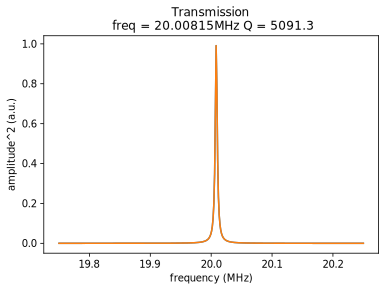

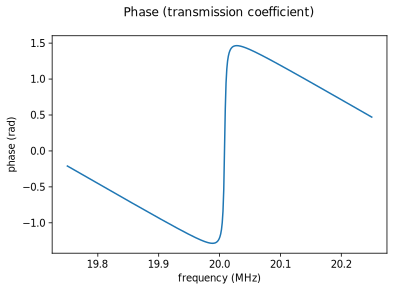

In [3]:
h5_file = h5py.File('results.h5', 'r')
data = h5_file['data']

# Gaussian function that we use to fit the resonance
def resonance_f(freq, freq_m, quality_factor, max_amplitude):
    omega = 2 * constants.pi * freq
    omega_m = 2 * constants.pi * freq_m
    gamma = omega_m / quality_factor
    return max_amplitude * omega_m**2 * gamma**2 / (((omega_m**2 - omega**2)**2 + gamma**2 * omega**2))

frequency = data['displacement']['frequency'][...]
# Average the probe points
displacement = np.mean(data['displacement']['displacement'], axis=0)
calibration_displacement = np.mean(data['calibration']['displacement'], axis=0)
reflection_coefficient = displacement / calibration_displacement
reflectivity = (np.abs(np.mean(data['displacement']['displacement'][...]**2, axis=0))/
                np.abs(np.mean(data['calibration']['displacement'][...]**2, axis=0)))

try:
    x_data = frequency
    y_data = reflectivity
    quality_factor_guess = 1e3
    freq_guess = x_data[np.argmax(y_data)]
    amplitude_guess = np.max(y_data)
    fit_result, covariance = scipy.optimize.curve_fit(resonance_f, x_data, y_data,
                                                      [freq_guess, quality_factor_guess, amplitude_guess])
    freq_m = fit_result[0]
    quality_factor = np.abs(fit_result[1])
    max_amplitude = fit_result[2]
    y_data_fit = resonance_f(x_data, freq_m, quality_factor, max_amplitude)

    fig = plt.figure()
    plt.plot(frequency / 1e6, reflectivity, frequency / 1e6, y_data_fit)
    plt.xlabel('frequency (MHz)')
    plt.ylabel('amplitude^2 (a.u.)')
    plt.title('Transmission\n' + 'freq = ' + "%.7g" % (freq_guess / 1e6) + 'MHz Q = ' + "%.6g" % quality_factor)
except:
    fig = plt.figure()
    plt.plot(frequency / 1e6, reflectivity)
    plt.xlabel('frequency (MHz)')
    plt.ylabel('amplitude^2 (a.u.)')
    plt.title('Transmission')

fig = plt.figure()
plt.plot(frequency / 1e6, np.angle(reflection_coefficient))
plt.xlabel('frequency (MHz)')
plt.ylabel('phase (rad)')
plt.title('Phase (transmission coefficient)\n')

plt.show()
h5_file.close()